In [ ]:
# default_exp production.__main__
from nbdev.showdoc import show_doc

# Catégorisez automatiquement des questions

> Ce notebook présente un algorithme de machine Learning qui assugne automatiquement des Tags pertinents à une question du site Stack Overflow.

In [ ]:
#export
# tables
import pandas as pd
import numpy as np
# graphics
import seaborn as sns
import matplotlib.pyplot as plt
# text processing
import nltk
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
# expressions
import re
# machine learning
from sklearn.model_selection import train_test_split
# Deal with html text
from bs4 import BeautifulSoup
# Multiprocessing
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

## Chargement des données 

### Concaténations de tous les inputs 

Plus on a des données d'entrées mieux c'est. Nous avons effectué 10  requêtes SQL afin d'avoir 10 fichiers csv: QueryResults.csv, QueryResults(1).csv à QueryResults(9).csv. Ces fichiers ont été générés en respectant la consignes qui demandait de faire des requêtes avec des contraintes sur les id.  Nos requêtes SQL ont été effectué sur les id compris entre 0 et 50 000. Chaque requête a pris les résultats non nuls dans une plage de 100 000 valeurs. Il y a eu différentes requêtes afin d'avoir des fichiers d'une taille inférieure à 25Mb.

Nous dump sql se trouve dans le fichier sql_requery.txt

In [ ]:
#export
df_main = pd.DataFrame(columns=["Id", "Title", "Body", "Tags"])

In [ ]:
#export
df_main = df_main.append(pd.read_csv("../input/QueryResults.csv"), ignore_index = True)
df_main = df_main.append(pd.read_csv("../input/QueryResults(1).csv"), ignore_index = True)
df_main = df_main.append(pd.read_csv("../input/QueryResults(2).csv"), ignore_index = True)
df_main = df_main.append(pd.read_csv("../input/QueryResults(3).csv"), ignore_index = True)
df_main = df_main.append(pd.read_csv("../input/QueryResults(4).csv"), ignore_index = True)
df_main = df_main.append(pd.read_csv("../input/QueryResults(5).csv"), ignore_index = True)
df_main = df_main.append(pd.read_csv("../input/QueryResults(6).csv"), ignore_index = True)
df_main = df_main.append(pd.read_csv("../input/QueryResults(7).csv"), ignore_index = True)
df_main = df_main.append(pd.read_csv("../input/QueryResults(8).csv"), ignore_index = True)
df_main = df_main.append(pd.read_csv("../input/QueryResults(9).csv"), ignore_index = True)

## Inspection générale des données 

### Title feature

In [ ]:
#export
for i in range(10):
    print(df_main.loc[i, "Title"])

How to convert decimal to double in C#?
Percentage width child element in absolutely positioned parent on Internet Explorer 7
In C#, how do I calculate someone's age based on a DateTime type birthday?
Calculate relative time in C#
Determine a user's timezone
Difference between Math.Floor() and Math.Truncate()
Filling a DataSet or DataTable from a LINQ query result set
Binary Data in MySQL
What is the fastest way to get the value of π?
Throw an error in a MySQL trigger


Nous devons supprimer les caractères spéciaux et les ponctuations. Nous alons écrire une fonction qui prend en entrée un text, supprimer les caractères spéciaux, les ponctuations et enleve les majuscules.  

In [ ]:
#export
def pre_tokenize(text):
    
    # Suppression des points
    text = text.replace('.', ' ')
    # Suppressions des ponctuations
    expr = ["\n"] #["?", ",", ".", "'", ";", ":", "!", "\n", "(", ")", "|", "_", "-", "`", "+", "-", "*", "/"]
    for char in expr:
        text = text.replace(char, ' ')
    # Miniscule
    text = str(np.char.lower(text))
    
    return text

In [ ]:
#export
df_main["Title"] = df_main["Title"].map(pre_tokenize)

Nous allons aplliquer la Lemmatization afin de donner aux mots de notre texte une forme neutre. Nous le faisons dans la fonction suivantes.

In [ ]:
#export
def lemmatize_text(text):

    lem = WordNetLemmatizer()
    text_lemmatized = []
    words = word_tokenize(text)
    for word in words:
        word = lem.lemmatize(word, "v")
        text_lemmatized.append(word)
    text = ' '.join(text_lemmatized)
    
    return text

In [ ]:
#export
df_main["Title"] = df_main["Title"].map(lemmatize_text)

In [ ]:
#export
df_main["Title_tokens"] = df_main["Title"].map(word_tokenize)

On est confronté à un problème, le 'word_tokenize' sépare les caractères comme «#» de «c#». Si "C#" est utilisé deux fois, le modèle trouvera deux mots identiques au lieu d'un. Additionnons tous les mots pour compter les fréquences. 

### Tags feature

In [ ]:
#export
for i in range(10):
    print(df_main.loc[i, "Tags"])

<c#><floating-point><type-conversion><double><decimal>
<html><css><internet-explorer-7>
<c#><.net><datetime>
<c#><datetime><time><datediff><relative-time-span>
<html><browser><timezone><user-agent><timezone-offset>
<.net><math>
<c#><linq><web-services><.net-3.5>
<mysql><database><binary-data><data-storage>
<performance><algorithm><language-agnostic><unix><pi>
<mysql><database><triggers>


Séparons les tags dans une liste pour mieux analyser.

In [ ]:
#export
df_main["Tags"] = df_main["Tags"].map(lambda field:field[1:-1].split('><'))

In [ ]:
#export
for i in range(10):
    print(df_main.loc[i, "Tags"])

['c#', 'floating-point', 'type-conversion', 'double', 'decimal']
['html', 'css', 'internet-explorer-7']
['c#', '.net', 'datetime']
['c#', 'datetime', 'time', 'datediff', 'relative-time-span']
['html', 'browser', 'timezone', 'user-agent', 'timezone-offset']
['.net', 'math']
['c#', 'linq', 'web-services', '.net-3.5']
['mysql', 'database', 'binary-data', 'data-storage']
['performance', 'algorithm', 'language-agnostic', 'unix', 'pi']
['mysql', 'database', 'triggers']


On peut ajouter, du moins temporairement un champ dans le DataFrame principale. C'est le nombre de tags par posts. Il pourrait être utilisé pour obtenir une distribution.

In [ ]:
#export
df_main["nb_tags"] = df_main["Tags"].map(lambda field:len(field))

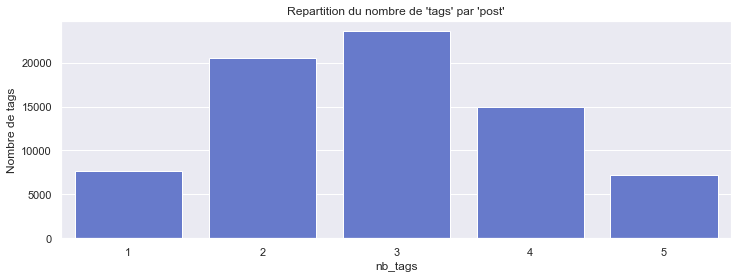

In [ ]:
#export
sns.set()
colors = sns.color_palette("hls", 8)
plt.figure(figsize=(12,4))
sns.countplot(df_main["nb_tags"], color=colors[5])
plt.title("Repartition du nombre de 'tags' par 'post'")
plt.ylabel("Nombre de tags")
plt.show()

Les valeurs uniques et leurs proportions numériques donnent des informations sur les articles avec 5 tags. Nous pouvons maintenant lister toutes les tags et voir les fréquentes

## Body feature 

In [ ]:
#export
df_main.loc[0:3, "Body"].values

array(['<p>I want to use a <code>Track-Bar</code> to change a <code>Form</code>\'s opacity.</p>\n<p>This is my code:</p>\n<pre class="lang-cs prettyprint-override"><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n<p>When I build the application, it gives the following error:</p>\n<blockquote>\n<p>Cannot implicitly convert type <code>decimal</code> to <code>double</code></p>\n</blockquote>\n<p>I have tried using <code>trans</code> and <code>double</code> but then the <code>Control</code> doesn\'t work. This code worked fine in a past VB.NET project.</p>\n',
       "<p>I have an absolutely positioned <code>div</code> containing several children, one of which is a relatively positioned <code>div</code>. When I use a <code>percentage-based width</code> on the child <code>div</code>, it collapses to <code>0 width</code> on IE7, but not on Firefox or Safari.</p>\n\n<p>If I use <code>pixel width</code>, it works. If the parent is relatively positioned, the 

Gestion de la Majuscule et des points...

In [ ]:
#export
df_main["Body"] = df_main["Body"].map(pre_tokenize)

Nous utilisons BeautifulSoup pour supprimer les tags html.

In [ ]:
#export
def get_soup(text):
    """ Retourne un texte , un soup sans tags html"""
    
    soup = BeautifulSoup(text, 'html.parser')
    return soup

In [ ]:
#export
df_main["Body_soup"] = df_main["Body"].map(lambda x: get_soup(x).get_text())

In [ ]:
#export
df_main["Body_soup"] = df_main["Body_soup"].map(lemmatize_text)

In [ ]:
#export
df_main["Body_tokens"] = df_main["Body_soup"].map(word_tokenize)

Étudions aussi les fréquences.

In [ ]:
#export
np_text = df_main["Body_tokens"].values.copy()
full_body_text_splitted = []
for i in range(len(np_text)):
    full_body_text_splitted.extend(np_text[i])
del np_text

Analyse des uniques

In [ ]:
#export
df_count = pd.DataFrame({"words":full_body_text_splitted}).words.value_counts()
df_count

the                         379880
,                           309035
i                           289821
to                          268225
a                           221647
                             ...  
//overwrite                      1
topixmap                         1
aop=                             1
coinit_disable_ole1dde           1
includes/jquery/jquery-1         1
Name: words, Length: 230588, dtype: int64

In [ ]:
#export
count = df_count.values
unique = df_count.index

In [ ]:
#export
np.concatenate((unique[0:100], unique[-100:]))

array(['the', ',', 'i', 'to', 'a', ')', '(', "''", 'is', 'and', ':', 'in',
       'of', '?', ';', 'that', 'it', 'this', '>', '<', 'for', '``',
       'have', '=', 'on', 'be', 'with', 'but', 'do', 'my', 'if', 'not',
       '{', 'as', '}', 'can', 'an', 'or', "'", "n't", 'there', 'are',
       "'m", 'from', 'what', 'like', 'so', "'s", 'using', '[', ']',
       'would', 'how', '--', 'you', 'any', 'when', 'use', 'code', 'way',
       'some', 'which', 'does', 'am', 'get', 'at', '0', 'all', '$',
       'file', '#', '1', 'new', 'want', 'one', 'data', 'will', 'we', 'by',
       'has', 'class', 'need', 'just', 'application', '-', 'string',
       'server', "'ve", 'know', 'me', 'c', '2', 'was', 'net', 'out',
       'other', '!', 'then', 'should', 'user',
       'm_permresource_radiobuttonlist', 'r_myrow', 'length-1-n',
       "'ix_indexname", ':builder', 'ip_banlist', 'tag_extensions',
       '\\231�027��w\\005\\b\\001\\000', 'drowning', "ps1='\\u",
       'buttonvectorcleanup', '/var/www/mysite/

In [ ]:
#export
count[np.where(count > 1000)]

array([379880, 309035, 289821, 268225, 221647, 210044, 207550, 143998,
       140726, 131704, 130871, 119345, 115734, 105217, 101969, 100823,
        99740,  90986,  89389,  80334,  77259,  66360,  65193,  61084,
        54593,  53647,  52121,  52094,  50321,  45484,  45042,  44503,
        43263,  43155,  42859,  42170,  42148,  38687,  37736,  36796,
        36524,  35648,  35273,  35232,  34244,  33859,  32523,  32167,
        31668,  31235,  31125,  30856,  30729,  29567,  28724,  27673,
        26420,  26173,  25854,  25053,  24610,  23877,  23067,  22740,
        22526,  22272,  22208,  22202,  22105,  21624,  21503,  21227,
        20896,  20851,  20328,  18333,  18034,  17630,  17455,  17317,
        17240,  17151,  17007,  16764,  16691,  16526,  16387,  16259,
        16198,  15069,  14802,  14730,  14701,  14679,  14436,  14268,
        14110,  14073,  14034,  13824,  13638,  13533,  13052,  12896,
        12888,  12741,  12652,  12551,  12535,  12438,  12400,  12231,
      

In [ ]:
#export
body_words_to_del = unique[np.where(count == 1)]
body_words_to_del

Index(['c1033', 'sqlbuddy\', 'wellknowntypescache', 'listitemview',
       '/path/executable/', '\\servername\jones', '\packed\bin', '-ddebugger',
       '1982-07-10', 'inmediatly',
       ...
       'someoutputpathfordll', 'tcp_closed', 'c:189', '10:00am-11:00am',
       ''projectfile', '//overwrite', 'topixmap', 'aop=',
       'coinit_disable_ole1dde', 'includes/jquery/jquery-1'],
      dtype='object', length=127395)

## Nettoyage et normalisation des données

### "Traning set" et "testing set"

In [ ]:
#export
xtrain, xtest = train_test_split(df_main, random_state=0)

df_test = df_main.loc[xtest.index]
df_test = df_test.reset_index()
df_test = df_test.drop("index", axis=1)

df_train = df_main.loc[xtrain.index]
df_train = df_train.reset_index()
df_train = df_train.drop("index", axis=1)

Nous allons essayer différentes méthodes de nettoyage pour obtenir un "bag of words".

- "Classic bag of words"(suppression des points, /n, html, minuscules, lematize):
    1.Aucune suppression des mots.
    2.Suppression des mots utilisés une seule fois.
    3.À partie des mots utilisés une seule fois, suppression de ceux qui ne sont pas dans le dictionnaire (trop bizarres comme mots).
    4.À partir des mots utilisés une seule fois, suppression des caractères spéciaux (*, +, -, ', #, nombres ... )
    
- "bag of words" avec suppression des "stopwords"(avec suppression des points, /n, html, minuscules, lematize), plus:
    1.Aucune suppression de mots
    2.Suppression des mots utilisés une seule fois
    3.À partir des mots utilisés une seule fois, suppression de ceux qui ne sont pas dans le dictionnaire (les mots bizarres)
    4.À partir des mots utilisés une seule fois, suppression des caractères spéciaux (*, +, -, ', #, nombres ...)
    
- "bag of words" TF-IDF(avec suppression des points, /n, html, minuscules, lematize), plus:
    1.Ne supprimez aucun mot
    2.Suppression des mots utilisés une seule fois
    3.À partir des mots utilisés une seule fois, suppression de ceux qui ne sont pas dans le dictionnaire (trop étranges)
    4.À partir des mots utilisés une seule fois, suppression des caractères spéciaux (*, +, -, ', #, nombres ... attachés aux mots)

### Classic Bag of word

#### 1. Aucune suppression de mots

Avec la focntion copy() nous ferrons du cleaning facilement

In [ ]:
#export
# Prendre le corpus dans les array.
text_train = df_train["Body_soup"].values.copy()
text_test = df_test["Body_soup"].values.copy()

In [ ]:
#export
debug = False
if debug:
    text_train = text_train[0:160]
    text_test = text_test[0:40]

In [ ]:
#export
# Création du transformeur
vectorizer = CountVectorizer(dtype=np.uint8)
# Tokenize build vocab
vectorizer.fit(text_train)
# Encodage du document
vector = vectorizer.transform(text_train)

In [ ]:
#export
dict(list(vectorizer.vocabulary_.items())[0:10])

{'would': 130070,
 'like': 70588,
 'to': 119653,
 'know': 68642,
 'how': 59315,
 'much': 78390,
 'disk': 40090,
 'space': 110096,
 'directory': 39812,
 'is': 65239}

Vérification de la mémoire du "bag of words"

In [ ]:
#export
nrows = len(text_train)
ncols = len(list(vectorizer.vocabulary_.items()))
print("Le 'bag of words' devrait avoir une taille de ({} * {}) en int8.".format(nrows, ncols))
print("La taille totale en mémoire sera de {} Go.".format(round(nrows * ncols * 8 / 1000000000)))

Le 'bag of words' devrait avoir une taille de (55456 * 132883) en int8.
La taille totale en mémoire sera de 59 Go.


Nous allons reduire notre échantillons à 15.000 pour notre traitement.

In [ ]:
#export
# Prendre le corpus dans les array.
text_train = df_train.loc[0:int(15000 * 0.8), "Body_soup"].values.copy()
text_test = df_test.loc[0:int(15000 * 0.2), "Body_soup"].values.copy()
if debug:
    text_train = text_train[0:160]
    text_test = text_test[0:40]
    
# Création du transformeur
vectorizer = CountVectorizer(dtype=np.uint8)
# Tokenize build vocab
vectorizer.fit(text_train)
# Encodage du document
vector = vectorizer.transform(text_train)

nrows = len(text_train)
ncols = len(list(vectorizer.vocabulary_.items()))
print("Le tarining 'bag of words' devrait avoir une taille de{} * {} in int8".format(nrows, ncols))
print("Ça taille totale en mémoire sera de {}Go".format(round(nrows * ncols * 1 / 1000000000, 2)))

Le tarining 'bag of words' devrait avoir une taille de12001 * 47229 in int8
Ça taille totale en mémoire sera de 0.57Go


Créons un "bag of words" dans lequel le nombre de lignes est égale au nombre de post, et le nombre de colonnes est égale au nombre total de mots uniques. La cellule sera le nombre d'occurrences de chaque mot.

In [ ]:
#export
reverse_dict = {}
for word, number in vectorizer.vocabulary_.items():
    reverse_dict[number] = word
    
bag_train = pd.DataFrame()
bag_train = bag_train.append(pd.DataFrame(vector.toarray()))
bag_train = bag_train.rename(columns=reverse_dict)

Pour la création du "bag of words" nous n'utiliserons que le "training set". Ceci dit, nous utilisons la méthode de la transformation vectorielle avec "testing set" et le vecteur fité sur le "training set". les mots présents dans le "testing set" serons supprimons.

In [ ]:
#export
# Encode document
vector_test = vectorizer.transform(text_test)
# Création du "bag of words"
bag_test = pd.DataFrame()
bag_test = bag_test.append(pd.DataFrame(vector_test.toarray()))
bag_test = bag_test.rename(columns=reverse_dict)

Sauvegarde du "bag of words"

In [ ]:
#export
bag_train["Id"] = df_train["Id"]
bag_train["Tags"] = df_train["Tags"]
bag_train["Train"] = 1

bag_test["Id"] = df_test["Id"]
bag_test["Tags"] = df_test["Tags"]
bag_test["Train"] = 0

bag_train = bag_train.append(bag_test)

In [ ]:
#export
bag_train.to_hdf("../output/classic_bag1.h5", index='False', key='stage', mode='w')

/Users/boleynkenkem/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['Id', 'Tags'], dtype='object')]

  encoding=encoding,


In [ ]:
#export
del bag_train
del bag_test
del vector
del vectorizer
del reverse_dict

#### 2. Suppression des mots utilisés une seule fois.

Duplication des 'feature'

In [ ]:
#export
def get_train_test(nb_rows=0):
    """ Prend en entrée les valeurs test et train en fonction des
    valeurs de debug """
    
    if nb_rows == 0:
        text_train = df_train["Body_soup"].values.copy()
        text_test = df_test["Body_soup"].values.copy()
    else:
        text_train = df_train.loc[0:int(nb_rows * 0.8), "Body_soup"].values.copy()
        text_test = df_test.loc[0:int(nb_rows * 0.2), "Body_soup"].values.copy()        
    
    if debug:
        text_train = text_train[0:16]
        text_test = text_test[0:4]
    
    return text_train, text_test

In [ ]:
#export
text_train, text_test = get_train_test(nb_rows = 15000)

Cleaning feature

In [ ]:
#export
def remove_unique_text(text, pd_words_to_del):
    """ À partir d'un texte et une liste de mots à supprimer, 
    retourne un texte cleaned sans ces mots. """
    
    tokens = word_tokenize(text)
    pd_tokens = pd.DataFrame({"words":tokens})
    pd_tokens = pd_tokens.loc[~pd_tokens["words"].isin(pd_words_to_del["words"].values)]
    
    return ' '.join(pd_tokens["words"].values)

In [ ]:
#export
def remove_unique_series(texts, pd_words_to_del, function, cores=1):
    """ 
    À partir d'une serie de textes et de mots à supprimer, retourne une serie sans 
    ces mots. 
    """
    
    if cores == 1:
        new_texts = []
        for i, text in enumerate(texts):
            new_text = remove_unique_text(text, pd_words_to_del)
            new_texts.append(new_text)
    
    else:
        inputs = tqdm(texts)
        new_texts = Parallel(n_jobs=cores)(delayed(function)(body, pd_words_to_del) for body in inputs)
    
    return new_texts

In [ ]:
#export
pd_body_words_to_del = pd.DataFrame({"words":body_words_to_del})

In [ ]:
#export
text_train = remove_unique_series(text_train, pd_body_words_to_del, remove_unique_text, 1)
text_test = remove_unique_series(text_test, pd_body_words_to_del, remove_unique_text, 1)

Construction du "bag of words"

In [ ]:
#export
def create_bag(text_train, text_test):
    """ Prend deux series de textes, train et test, et retourne
    un 'bag of words'
    """
    
    # Créate du transformeur
    vectorizer = CountVectorizer(dtype=np.uint8)
    # Tokenize, build vocab
    vectorizer.fit(text_train)
    # Encodage document
    vector = vectorizer.transform(text_train)
    
    reverse_dict = {}
    for word, number in vectorizer.vocabulary_.items():
        reverse_dict[number] = word

    bag_train = pd.DataFrame()
    bag_train = bag_train.append(pd.DataFrame(vector.toarray()))
    bag_train = bag_train.rename(columns=reverse_dict)
    
    # Encodage test document
    vector_test = vectorizer.transform(text_test)
    # Création du 'bag of words'
    bag_test = pd.DataFrame()
    bag_test = bag_test.append(pd.DataFrame(vector_test.toarray()))
    bag_test = bag_test.rename(columns=reverse_dict)
    
    return bag_train, bag_test

In [ ]:
#export
bag_train, bag_test = create_bag(text_train, text_test)

In [ ]:
#export
def save_bags(bag_train, bag_test, method, number):
    """ Sauvegarde des bags avec les noms suivants '../output/<method>_bag<number>.csv' """
    
    bag_train["Id"] = df_train["Id"]
    bag_train["Tags"] = df_train["Tags"]
    bag_train["Train"] = 1

    bag_test["Id"] = df_test["Id"]
    bag_test["Tags"] = df_test["Tags"]
    bag_test["Train"] = 0

    bag_train = bag_train.append(bag_test)
    print("Le 'bag' entier a un nombre total de {} mots".format(bag_train.shape[1]))
    bag_train.to_hdf("../output/" + method + "_bag" + number + ".h5", index='False', key='stage', mode='w')

In [ ]:
#export
save_bags(bag_train, bag_test, "classic", "2")
del bag_train
del bag_test

Le 'bag' entier a un nombre total de 33499 mots


#### 3. À partie des mots utilisés une seule fois, suppression de ceux qui ne sont pas dans le dictionnaire.

Duplication des 'features'

In [ ]:
#export
text_train, text_test = get_train_test(nb_rows = 15000)

Suppression des mots étranges, mots présents dans le dictionnaire, de notre fichier.

In [ ]:
#export
pd_words_to_del2 = pd.DataFrame({"words":body_words_to_del})
pd_words_to_del2 = pd_words_to_del2.loc[~pd_words_to_del2["words"].isin(words.words()).values]

In [ ]:
#export
text_train = remove_unique_series(text_train, pd_words_to_del2, remove_unique_text, 1)
text_test = remove_unique_series(text_test, pd_words_to_del2, remove_unique_text, 1)

In [ ]:
#export
bag_train, bag_test = create_bag(text_train, text_test)

In [ ]:
#export
save_bags(bag_train, bag_test, "classic", "3")
del bag_train
del bag_test

Le 'bag' entier a un nombre total de 34067 mots


#### 4. À partir des mots utilisés une seule fois, suppression des caractères spéciaux.

In [ ]:
#export
text_train, text_test = get_train_test(nb_rows = 15000)

In [ ]:
#export
def remove_unique_without_spe_text(text, words_to_del):
    """ À partir d'un texte et des mots à supprimés, 
        retourne un sans carcatères spéciaux. """
    

    # Suppression des ponctuations
    expr = ["?", ",", ".", "'", ";", ":", "!", 
            "(", ")", "{", "}", "[", "]",
            "|", "_", "`", "'", "#", "&", "$",
            "+", "-", "*", "/", "=", "<", ">",
            "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    for char in expr:
        text = text.replace(char, ' ') 
    
    return text

In [ ]:
#export
text_train = remove_unique_series(text_train, np.nan, remove_unique_without_spe_text, 1)
text_test = remove_unique_series(text_test, np.nan, remove_unique_without_spe_text, 1)

TypeError: 'float' object is not subscriptable

In [ ]:
#export
bag_train, bag_test = create_bag(text_train, text_test)

In [ ]:
#export
save_bags(bag_train, bag_test, "classic", "4")
del bag_train
del bag_test

### 'Bag of words' Suppression des 'stopwords' - Frequence

In [ ]:
#export
def remove_stopwords(df_bag):
    """ À partir du 'bag of words' suppression des 
          'stopwords' """
    
    # Suppression des colonnes sans mots
    cols = np.array(df_bag.columns)
    cols = np.delete(cols, np.where(~np.isin(cols, ["Id", "Tags", 'Train'], invert=True)))
    
    # Suppression des colonnes qui sont les 'stopwords'
    col_to_del = []
    for col in cols:
        if col in stopwords.words():
            col_to_del.append(col)
            
    df_bag.drop(col_to_del, axis=1, inplace=True)
    
    return df_bag

In [ ]:
#export
df_bag = pd.read_hdf("output/classic_bag1.h5", index='False', key='stage', mode='r')

In [ ]:
#export
print("Le 'bag' entier avait un nombre de {} mots".format(df_bag.shape[1]))
df_bag = remove_stopwords(df_bag)
print("Le 'bag' entier a maintenant un nombre total de {} mots".format(df_bag.shape[1]))

In [ ]:
#export
df_bag.to_hdf("output/stopwords_bag" + "1" + ".h5", index='False', key='stage', mode='w')

NameError: name 'df_bag' is not defined

In [ ]:
#export

In [ ]:
#export

In [ ]:
#export

In [ ]:
#export

In [ ]:
#export

In [ ]:
#export